In [1]:
import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import datetime
from config import *
import sklearn 
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

sns.set(rc={'figure.figsize':(16,6)})

In [2]:
dEv = pd.read_csv(DATA_PATH + '/out/aggEvents.csv')
dStatus = pd.read_csv(DATA_PATH + '/out/aggStatus.csv')
dEv['time1'] = pd.to_datetime(dEv['time1'])
dEv

,asset_id,time1,sensor,min,max,dist
0,1,2016-08-11,NaN,NaN,NaN,1.121111
1,1,2016-08-12,NaN,NaN,NaN,0.012886
2,1,2016-08-13,NaN,NaN,NaN,0.012886
3,1,2016-08-14,NaN,NaN,NaN,0.012886
4,1,2016-08-15,NaN,NaN,NaN,0.012886
...,...,...,...,...,...,...
110620,68202,2018-04-07,8.541667,8.0,9.0,0.000000
110621,68202,2018-04-08,8.767857,8.5,9.0,0.000000
110622,68202,2018-04-09,9.255319,9.0,9.5,0.000000
110623,68202,2018-04-10,10.239583,9.5,11.5,0.000000


In [3]:
brokenAssets = dStatus.groupby('asset_id').max()
brokenAssetsId = brokenAssets[brokenAssets['status']>1].index

In [4]:
brokenAssetsId

Int64Index([    1,     6,     7,     9,    10,    11,    12,    13,    14,
               15,
            ...
            62846, 62853, 65773, 65893, 65970, 66301, 66304, 66356, 67432,
            67906],
           dtype='int64', name='asset_id', length=282)

In [5]:
##########   Here we start model building  ############
###  Labels: 
##       a. split into good / bad samples, labelled respectively
##       b. good ones have labels-0, bad ones have labels-1


##   X: go back T_r (range) days from the end date, interpolate the missing data

## 1. find T_r by statistics (result is 350, most assets have this range) 
##    - then drop short date
##    - then split/convert [asset-id, time] into asset-id indexed samples
##    - then truncate data from: end - T_r  
#     - then interpolate mean value

# statsDaysGrp = dEv.groupby(['asset_id', 'time1']).max().reset_index()
# statsDays = statsDaysGrp.groupby('asset_id').count()[['time1', 'dist']]
# statsDays['range'] = [x.days for x in 
#                       statsDaysGrp.groupby('asset_id').max()['time1'] - statsDaysGrp.groupby('asset_id').min()['time1']]

# assetLong = statsDays[statsDays['range'] > 300].index
# dEv = dEv[dEv['asset_id'].isin(assetLong)] ## drop short-date
# endDate = statsDaysGrp.groupby('asset_id').max()['time1'] ## end date

T = 300
def dataFlatten(df, T): ## handle one asset accross time
    endDate = df['time1'].max()
    mins = np.ones(T) * df['min'].mean(skipna = True)
    maxs = np.ones(T) * df['max'].mean(skipna = True)
    means = np.ones(T) * df['sensor'].mean(skipna = True)
    dists = np.zeros(T)
    
    df2 = df.copy()
    
    df2['min'] = df['min'].fillna(mins[0])
    df2['max'] = df['max'].fillna(maxs[0])
    df2['sensor'] = df['sensor'].fillna(means[0])
    
    for r, d in df2.iterrows():
        daysDiff = (endDate - d['time1']).days
        if daysDiff < T:
            if d['min'] == d['min']:
                mins[daysDiff] = d['min']
                maxs[daysDiff] = d['max']
                means[daysDiff] = d['sensor']
            dists[daysDiff] = d['dist']
            
    return np.array([mins, maxs, means, dists])

X = {}
for i in dEv['asset_id'].unique():
    X[i] = dataFlatten(dEv[dEv['asset_id'] == i], T=T)



In [6]:
a = list(X.values()) 
len(a), a[0].shape

(996, (4, 300))

In [7]:
### features
def featureFlat(mat):
    return mat.reshape(-1)

def featureStats(mat):
    return np.array( list(mat.mean(axis = 1)) + [min(mat[0]), max(mat[1])] )

Y, X_flat, X_stats = [], [], []
for k,v in X.items():
    X_flat += [featureFlat(v)]
    X_stats += [featureStats(v)]
    Y += [ int(k in brokenAssetsId) ]
    
X_flat, X_stats, Y = np.array(X_flat), np.array(X_stats), np.array(Y)
X_flat.shape, X_stats.shape, Y.shape


((996, 1200), (996, 6), (996,))

In [8]:
goodAssetsId = set(dEv['asset_id'].unique()) - set(brokenAssetsId)
a = dEv[dEv['asset_id'].isin(brokenAssetsId)].groupby('asset_id').sum()
brokenNomovedId = a[a['dist'] <= 0].index
brokenMovedId = a[a['dist'] > 0].index
b = dEv[dEv['asset_id'].isin(goodAssetsId)].groupby('asset_id').sum()



In [9]:
### split
skf = StratifiedKFold(n_splits=5, shuffle=True)
for train_idx, test_idx in skf.split(X_stats, Y):
    xtrain, ytrain = np.array(X_flat)[train_idx], np.array(Y)[train_idx]
    xtest, ytest = np.array(X_flat)[test_idx], np.array(Y)[test_idx]
    break

### svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(xtrain, ytrain)
clf[1].support_
clf.score(xtest, ytest)

0.945

score:  0.965
mins, maxs, means, dists, totalMin, totalMax
|--- feature_2 <= 13.78
|   |--- feature_3 <= 0.00
|   |   |--- class: 1
|   |--- feature_3 >  0.00
|   |   |--- feature_3 <= 0.01
|   |   |   |--- class: 0
|   |   |--- feature_3 >  0.01
|   |   |   |--- class: 0
|--- feature_2 >  13.78
|   |--- feature_1 <= 16.23
|   |   |--- feature_3 <= 0.00
|   |   |   |--- class: 1
|   |   |--- feature_3 >  0.00
|   |   |   |--- class: 0
|   |--- feature_1 >  16.23
|   |   |--- feature_1 <= 23.14
|   |   |   |--- class: 1
|   |   |--- feature_1 >  23.14
|   |   |   |--- class: 0



[Text(377.7230769230769, 285.39000000000004, 'X[2] <= 13.78\ngini = 0.404\nsamples = 796\nvalue = [572, 224]\nclass = good'),
 Text(137.35384615384615, 203.85000000000002, 'X[3] <= 0.0\ngini = 0.061\nsamples = 569\nvalue = [551, 18]\nclass = good'),
 Text(68.67692307692307, 122.31, 'gini = 0.0\nsamples = 13\nvalue = [0, 13]\nclass = broken'),
 Text(206.03076923076924, 122.31, 'X[3] <= 0.006\ngini = 0.018\nsamples = 556\nvalue = [551, 5]\nclass = good'),
 Text(137.35384615384615, 40.76999999999998, 'gini = 0.0\nsamples = 545\nvalue = [545, 0]\nclass = good'),
 Text(274.7076923076923, 40.76999999999998, 'gini = 0.496\nsamples = 11\nvalue = [6, 5]\nclass = good'),
 Text(618.0923076923077, 203.85000000000002, 'X[1] <= 16.234\ngini = 0.168\nsamples = 227\nvalue = [21, 206]\nclass = broken'),
 Text(480.73846153846154, 122.31, 'X[3] <= 0.0\ngini = 0.497\nsamples = 26\nvalue = [12, 14]\nclass = broken'),
 Text(412.0615384615385, 40.76999999999998, 'gini = 0.0\nsamples = 13\nvalue = [0, 13]\ncl

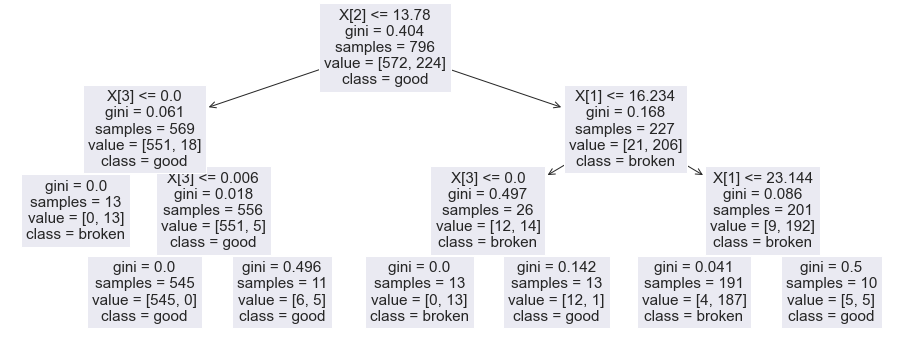

In [10]:
### split
skf = StratifiedKFold(n_splits=5, shuffle=True)
for train_idx, test_idx in skf.split(X_stats, Y):
    xtrain, ytrain = np.array(X_stats)[train_idx], np.array(Y)[train_idx]
    xtest, ytest = np.array(X_stats)[test_idx], np.array(Y)[test_idx]
    break

### decistion tree
clf = make_pipeline(tree.DecisionTreeClassifier(max_depth=3))
clf.fit(xtrain, ytrain)
print('score: ', clf.score(xtest, ytest))

print('mins, maxs, means, dists, totalMin, totalMax')
print(tree.export_text(clf[0]))
tree.plot_tree(clf[0], class_names = ['good', 'broken'])

score:  0.925
mins, maxs, means, totalMin, totalMax
|--- feature_1 <= 14.87
|   |--- feature_4 <= 24.75
|   |   |--- feature_1 <= 13.08
|   |   |   |--- class: 0
|   |   |--- feature_1 >  13.08
|   |   |   |--- class: 0
|   |--- feature_4 >  24.75
|   |   |--- feature_3 <= 7.75
|   |   |   |--- class: 1
|   |   |--- feature_3 >  7.75
|   |   |   |--- class: 0
|--- feature_1 >  14.87
|   |--- feature_2 <= 15.49
|   |   |--- feature_3 <= 9.25
|   |   |   |--- class: 1
|   |   |--- feature_3 >  9.25
|   |   |   |--- class: 0
|   |--- feature_2 >  15.49
|   |   |--- feature_1 <= 23.14
|   |   |   |--- class: 1
|   |   |--- feature_1 >  23.14
|   |   |   |--- class: 1



[Text(446.4, 285.39000000000004, 'X[1] <= 14.868\ngini = 0.404\nsamples = 796\nvalue = [572, 224]\nclass = good'),
 Text(223.2, 203.85000000000002, 'X[4] <= 24.75\ngini = 0.055\nsamples = 568\nvalue = [552, 16]\nclass = good'),
 Text(111.6, 122.31, 'X[1] <= 13.08\ngini = 0.038\nsamples = 562\nvalue = [551, 11]\nclass = good'),
 Text(55.8, 40.76999999999998, 'gini = 0.015\nsamples = 531\nvalue = [527, 4]\nclass = good'),
 Text(167.39999999999998, 40.76999999999998, 'gini = 0.35\nsamples = 31\nvalue = [24, 7]\nclass = good'),
 Text(334.79999999999995, 122.31, 'X[3] <= 7.75\ngini = 0.278\nsamples = 6\nvalue = [1, 5]\nclass = broken'),
 Text(279.0, 40.76999999999998, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = broken'),
 Text(390.59999999999997, 40.76999999999998, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = good'),
 Text(669.5999999999999, 203.85000000000002, 'X[2] <= 15.494\ngini = 0.16\nsamples = 228\nvalue = [20, 208]\nclass = broken'),
 Text(558.0, 122.31, 'X[3] <= 9.25\ngi

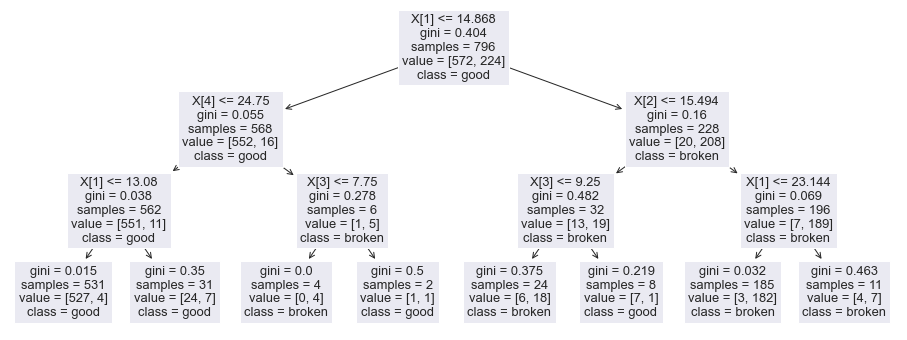

In [11]:
### Exp 2: with no distance input, for the data is biased
### split
X_stats2 = X_stats[:, [0,1,2,4,5]]
skf = StratifiedKFold(n_splits=5, shuffle=True)
for train_idx, test_idx in skf.split(X_stats, Y):
    xtrain, ytrain = np.array(X_stats2)[train_idx], np.array(Y)[train_idx]
    xtest, ytest = np.array(X_stats2)[test_idx], np.array(Y)[test_idx]
    break

### decistion tree
clf = make_pipeline(tree.DecisionTreeClassifier(max_depth=3))
clf.fit(xtrain, ytrain)
print('score: ', clf.score(xtest, ytest))

print('mins, maxs, means, totalMin, totalMax')
print(tree.export_text(clf[0]))
tree.plot_tree(clf[0], class_names = ['good', 'broken'])

score:  0.9529411764705882
mins, maxs, means, dist, totalMin, totalMax
|--- feature_2 <= 15.53
|   |--- feature_3 <= 0.00
|   |   |--- feature_3 <= 0.00
|   |   |   |--- class: 0
|   |   |--- feature_3 >  0.00
|   |   |   |--- class: 0
|   |--- feature_3 >  0.00
|   |   |--- feature_1 <= 11.62
|   |   |   |--- class: 0
|   |   |--- feature_1 >  11.62
|   |   |   |--- class: 0
|--- feature_2 >  15.53
|   |--- feature_1 <= 22.02
|   |   |--- feature_0 <= 16.66
|   |   |   |--- class: 1
|   |   |--- feature_0 >  16.66
|   |   |   |--- class: 1
|   |--- feature_1 >  22.02
|   |   |--- feature_4 <= 13.25
|   |   |   |--- class: 0
|   |   |--- feature_4 >  13.25
|   |   |   |--- class: 1



[Text(446.4, 285.39000000000004, 'X[2] <= 15.529\ngini = 0.266\nsamples = 679\nvalue = [572, 107]\nclass = good'),
 Text(223.2, 203.85000000000002, 'X[3] <= 0.001\ngini = 0.021\nsamples = 570\nvalue = [564, 6]\nclass = good'),
 Text(111.6, 122.31, 'X[3] <= 0.0\ngini = 0.004\nsamples = 557\nvalue = [556, 1]\nclass = good'),
 Text(55.8, 40.76999999999998, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = good'),
 Text(167.39999999999998, 40.76999999999998, 'gini = 0.0\nsamples = 555\nvalue = [555, 0]\nclass = good'),
 Text(334.79999999999995, 122.31, 'X[1] <= 11.616\ngini = 0.473\nsamples = 13\nvalue = [8, 5]\nclass = good'),
 Text(279.0, 40.76999999999998, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]\nclass = good'),
 Text(390.59999999999997, 40.76999999999998, 'gini = 0.5\nsamples = 10\nvalue = [5, 5]\nclass = good'),
 Text(669.5999999999999, 203.85000000000002, 'X[1] <= 22.02\ngini = 0.136\nsamples = 109\nvalue = [8, 101]\nclass = broken'),
 Text(558.0, 122.31, 'X[0] <= 16.659\ngini = 0.0

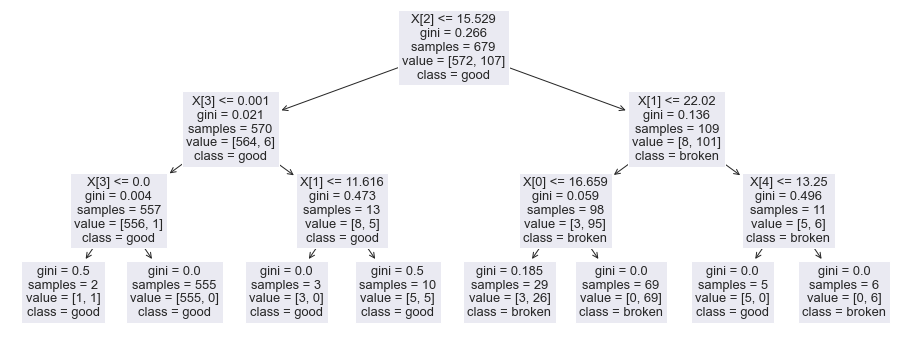

In [13]:
### Exp 3: with distance input, discard non-moved devices

Y3, X_flat3, X_stats3 = [], [], []
for k,v in X.items():
    if k not in brokenNomovedId:
        X_flat3 += [featureFlat(v)]
        X_stats3 += [featureStats(v)]
        Y3 += [ int(k in brokenAssetsId) ]
    
X_flat3, X_stats3, Y3 = np.array(X_flat3), np.array(X_stats3), np.array(Y3)

skf = StratifiedKFold(n_splits=5, shuffle=True)
for train_idx, test_idx in skf.split(X_stats3, Y3):
    xtrain, ytrain = np.array(X_stats3)[train_idx], np.array(Y3)[train_idx]
    xtest, ytest = np.array(X_stats3)[test_idx], np.array(Y3)[test_idx]
    break

### decistion tree
clf = make_pipeline(tree.DecisionTreeClassifier(max_depth=3))
clf.fit(xtrain, ytrain)
print('score: ', clf.score(xtest, ytest))

print('mins, maxs, means, dist, totalMin, totalMax')
print(tree.export_text(clf[0]))
tree.plot_tree(clf[0], class_names = ['good', 'broken'])

In [ ]:
sns.histplot(X_stats3[:, 3] * 10000)

<AxesSubplot:ylabel='Count'>